In [2]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lifelines

In [55]:
#loading dataframes, and getting rid of some columns
df_profiles=pd.read_json('profiles_1512362725.022629.json')
df_games=pd.read_json('games_1512362753.8735218.json')
df_profiles=df_profiles.drop(['current_team', 'birth_place', 'death_date', 'college', 'high_school', 'draft_team', 'current_salary', 'hof_induction_year', 'draft_position'], axis=1)
df_games=df_games[['player_id', 'year', 'game_number', 'passing_attempts', 'passing_completions', 'passing_yards', 'passing_rating', 'passing_touchdowns', 'passing_interceptions', 'passing_sacks', 'rushing_attempts', 'rushing_yards', 'rushing_touchdowns', 'receiving_receptions', 'receiving_yards','receiving_touchdowns','kick_return_attempts', 'punt_return_attempts', 'defense_sacks', 'defense_tackles', 'defense_interceptions', 'field_goal_attempts', 'field_goal_makes']]
df_games=df_games.rename(columns = {'passing_completions': 'temp'})
df_games=df_games.rename(columns = {'passing_attempts': 'passing_completions'})
df_games=df_games.rename(columns = {'temp': 'passing_attempts'})
df_games.head(5)

,player_id,year,game_number,passing_completions,passing_attempts,passing_yards,passing_rating,passing_touchdowns,passing_interceptions,passing_sacks,...,receiving_receptions,receiving_yards,receiving_touchdowns,kick_return_attempts,punt_return_attempts,defense_sacks,defense_tackles,defense_interceptions,field_goal_attempts,field_goal_makes
0,1809,1990,1,0,0,0,0.0,0,0,0,...,0,0,0,0,0,0.0,0,0,0,0
1,1809,1990,2,0,0,0,0.0,0,0,0,...,0,0,0,0,0,0.0,0,0,0,0
2,1809,1990,3,0,0,0,0.0,0,0,0,...,0,0,0,0,0,0.0,0,0,0,0
3,1809,1990,4,0,0,0,0.0,0,0,0,...,0,0,0,0,0,0.0,0,0,0,0
4,1809,1990,5,0,0,0,0.0,0,0,0,...,0,0,0,0,0,0.0,0,0,0,0


In [148]:
#creating the aggregated stats dataframe

df_stats=df_games.drop(['year', 'game_number', 'passing_rating'], axis=1).groupby('player_id').sum().reset_index()
df_played=df_games.groupby('player_id').size().reset_index()
df_played=df_played.rename(columns = {0: 'games'})
df_seasons=df_games.groupby(['player_id', 'year']).size().reset_index().groupby('player_id').size().reset_index()
df_seasons=df_seasons.rename(columns = {0: 'seasons'})
df_last_year=df_games.groupby('player_id').max()['year'].reset_index()
df_last_year=df_last_year.rename(columns = {'year': 'max_year'})
df_first_year=df_games.groupby('player_id').min()['year'].reset_index()
df_first_year=df_first_year.rename(columns = {'year': 'min_year'})
df_stats=df_stats.merge(df_played, how='inner', on='player_id')
df_stats=df_stats.merge(df_seasons, how='inner', on='player_id')
df_stats=df_stats.merge(df_last_year, how='inner', on='player_id')
df_stats=df_stats.merge(df_first_year, how='inner', on='player_id')


df_stats.head(5)

,player_id,passing_completions,passing_attempts,passing_yards,passing_touchdowns,passing_interceptions,passing_sacks,rushing_attempts,rushing_yards,rushing_touchdowns,...,punt_return_attempts,defense_sacks,defense_tackles,defense_interceptions,field_goal_attempts,field_goal_makes,games,seasons,max_year,min_year
0,1,0,0,0,0,0,0,0,0,0,...,0,0.0,1,0,0,0,4,1,2013,2013
1,4,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,34,21,23,2,1988,1987
2,5,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,23,3,2017,2015
3,7,0,0,0,0,0,0,0,0,0,...,0,0.0,1,0,0,0,2,1,2016,2016
4,8,0,0,0,0,0,0,1039,3527,34,...,0,0.0,0,0,0,0,64,5,2000,1996


In [131]:
#changing total stats to season averages - second version, i think this messes with my avgs

#for column in df_stats.drop(['player_id', 'seasons', 'max_year', 'min_year'], axis=1).columns:
#for column in ['games']:
#    df_stats[column]= df_stats[column]/df_stats['seasons']



In [158]:
#profile + stats df

df=df_profiles.merge(df_stats, on='player_id', how='inner')
df=df[df['height']!='None']
df['lifetime']=np.where(pd.isnull(df['draft_year']), df['max_year']-df['min_year'] +1 ,df['max_year']-df['draft_year'] +1)
df['draft_age']=np.where(pd.isnull(df['draft_year']), df['min_year']-[int(x[0:4]) for x in df['birth_date']], df['draft_year']-[int(x[0:4]) for x in df['birth_date']])
df['height2']=[str(x)[0] for x in df['height']]
df=df[df['height2']!='N']
df['height']=[int(str(x)[0])*12+int(str(x)[2]) for x in df['height']]
df['draft_round']=df['draft_round'].fillna(100)

#any data pertraining 2017 is censored (we don't know it the guy came back in 2018)
df['retired']=np.where(df['max_year']==2017, 0 ,1)

df=df.drop(['height2', 'max_year', 'draft_year', 'birth_date'], axis=1)


df.head(5)

,player_id,name,position,height,weight,draft_round,passing_completions,passing_attempts,passing_yards,passing_touchdowns,...,defense_tackles,defense_interceptions,field_goal_attempts,field_goal_makes,games,seasons,min_year,lifetime,draft_age,retired
0,1809,Robert Blackmon,DB,72,208.0,2.0,0,0,0,0,...,0,17,0,0,134,9,1990,9.0,23.0,1
1,23586,Dean Wells,LB,75,248.0,4.0,0,0,0,0,...,0,3,0,0,129,9,1993,9.0,23.0,1
2,355,Kiko Alonso,ILB,75,238.0,2.0,0,0,0,0,...,240,7,0,0,54,4,2013,5.0,23.0,0
3,18182,Steve Ramsey,QB,74,210.0,5.0,456,921,6437,35,...,0,0,0,0,54,7,1970,7.0,22.0,1
4,16250,Cory Nelms,CB,72,195.0,100.0,0,0,0,0,...,0,0,0,0,1,1,2012,1.0,24.0,1


Text(0, 0.5, 'Lifetime')

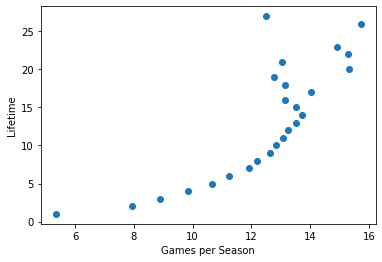

In [42]:
#checking a supposed nonlinear effect between lifetime and body stress (number of games played and rushing)

#df_plot=df[df['position']=='LB'].groupby('lifetime')['games'].mean().reset_index()
df_plot=df.groupby('lifetime')['games'].mean().reset_index()
plt.scatter(df_plot['games'], df_plot['lifetime'])
plt.xlabel('Games per Season')
plt.ylabel('Lifetime')

In [133]:
#creating the first cox regression, with positions only as covariates

df_filter=df.groupby('position').size().reset_index()
df_filter=df_filter[df_filter[0]>50]
df_filter=df_filter.drop(0, axis=1)

group=[]
for row in range(len(df_filter.index)):
    if df_filter.iloc[row, 0] in ['RB', 'HB', 'FB']:
        group.append('runner')
    elif df_filter.iloc[row, 0]  in ['QB']:
        group.append('qb')
    elif df_filter.iloc[row, 0]  in ['K', 'P']:
        group.append('special')
    elif df_filter.iloc[row, 0]  in ['WR', 'TE']:
        group.append('receiver')
    elif df_filter.iloc[row, 0]  in ['C', 'G', 'C-G', 'G-T', 'OT', 'T-G', 'G-C', 'OG', 'T']:
        group.append('o-line')
    elif df_filter.iloc[row, 0]  in ['DE', 'DT', 'DE-DT', 'DT-DE', 'NT', 'E', 'DE-LB']:
        group.append('d-line')
    elif df_filter.iloc[row, 0]  in ['LB', 'OLB', 'ILB', 'LB-DE']:
        group.append('lb')
    elif df_filter.iloc[row, 0]  in ['CB', 'DB', 'S', 'DB-HB', 'FS', 'SS']:
        group.append('secondary')

df_filter['group']=group

df_cox=df[['position', 'lifetime', 'retired']]
#df_cox=df[['position', 'lifetime']]
df_cox=df_cox.merge(df_filter, on='position', how='inner')

df_cox=df_cox.drop('position', axis=1)
df_cox = pd.get_dummies(df_cox, columns=['group'])

cph = lifelines.CoxPHFitter(penalizer=0.0001)
cph.fit(df_cox, duration_col='lifetime', event_col='retired')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 17736 total observations, 1810 right-censored observations>
             duration col = 'lifetime'
                event col = 'retired'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 17736
number of events observed = 15926
   partial log-likelihood = -139562.48
         time fit was run = 2021-10-18 13:57:20 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
group_d-line     -0.06       0.94       0.81            -1.66             1.53                 0.19                 4.62
group_lb          0.02       1.02       0.81            -1.57             1.62                 0.21                 5.05
group_o-line     -0.16       0.85       0.81            -1.76             1.43                 0.17                 4.19
group_qb         -0.47       0.63       0.81            -2.06             1.13                 0.13                 3.09
group_receiver    0.13       1.14       0.81            -1.46             1.73                 0.23                 5.62
group_runner      0.26       1.30       0.81            -1.33             1.86                 0.26                 6.42
group_secondary   0.06       1.06       0.81            -1.54             1.65                 0.22                 5.22
group_special    -0.46       0.63       0.81            -2.05             1.14                 0.13                 3.12

                    z    p   -log2(p)
covariate                            
group_d-line    -0.08 0.94       0.09
group_lb         0.03 0.98       0.04
group_o-line    -0.20 0.84       0.25
group_qb        -0.57 0.57       0.82
group_receiver   0.16 0.87       0.20
group_runner     0.33 0.74       0.43
group_secondary  0.07 0.94       0.09
group_special   -0.56 0.57       0.80
---
Concordance = 0.54
Partial AIC = 279140.96
log-likelihood ratio test = 539.01 on 8 df
-log2(p) of ll-ratio test = 367.16

In [120]:
df_filter=df.groupby('position').size().reset_index()
df_filter=df_filter[df_filter[0]>50]
pd.options.display.max_rows = 10
df_filter.sort_values(0, ascending=False)
df_filter.head(5)



,position,0
6,C,389
11,C-G,110
20,CB,266
21,DB,2907
28,DB-HB,72


<ipython-input-215-0df719a40fb0>:38: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


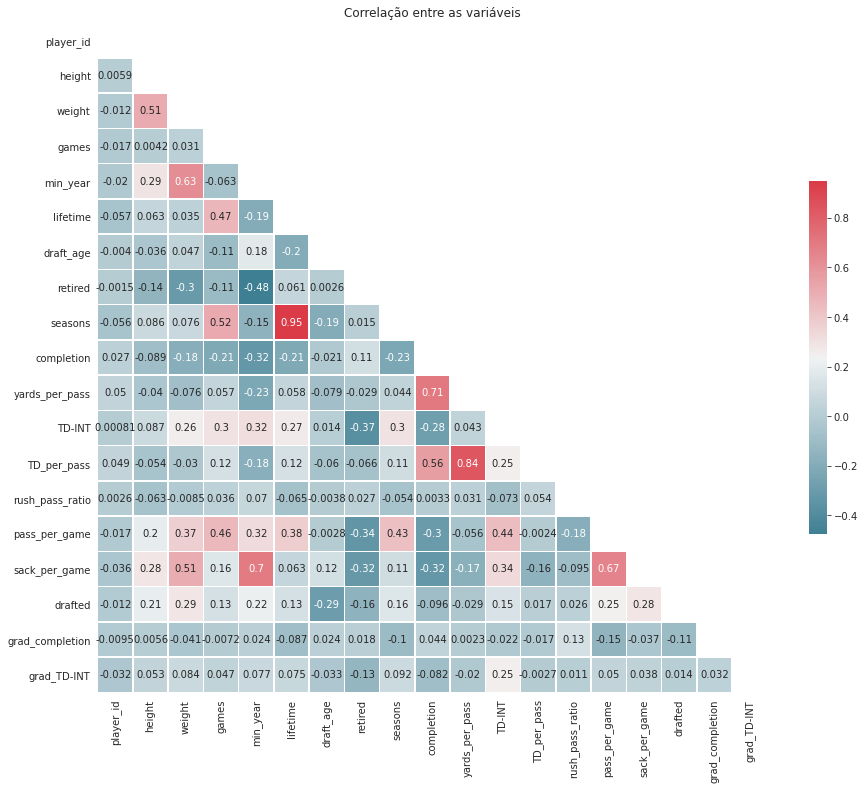

In [215]:
#correlation between variables
import seaborn as sns

df_cox=df[df['position']=='QB'][['player_id','height', 'weight', 'draft_round','passing_attempts', 'passing_completions', 'passing_yards','passing_touchdowns', 'passing_interceptions', 'passing_sacks','rushing_attempts', 'rushing_yards','games', 'min_year', 'lifetime', 'draft_age','retired', 'seasons']]
#df_cox['completion']=(df_cox['passing_completions']/df_cox['passing_attempts'].replace(to_replace=0, value=1)).fillna(0)
df_cox['completion']=(df_cox['passing_attempts']/df_cox['passing_completions'].replace(to_replace=0, value=1)).fillna(0)
df_cox['yards_per_pass']=(df_cox['passing_yards']/df_cox['passing_completions']).fillna(0)
df_cox['TD-INT']=(df_cox['passing_touchdowns']/df_cox['passing_interceptions'].replace(to_replace=0, value=1))
#df_cox['TD_per_pass']=(df_cox['passing_touchdowns']/df_cox['passing_completions']).fillna(0)
df_cox['TD_per_pass']=(df_cox['passing_touchdowns']/df_cox['passing_completions']).fillna(0)
df_cox['rush_pass_ratio']=(df_cox['rushing_attempts']/df_cox['passing_attempts'].replace(to_replace=0, value=1)).fillna(0)
df_cox['pass_per_game']=(df_cox['passing_attempts']/df_cox['games']).fillna(0)
df_cox['sack_per_game']=(df_cox['passing_sacks']/df_cox['games']).fillna(0)
#df_cox['draft_round']=np.where(df_cox['draft_round']==100, 'undrafted', np.where(df_cox['draft_round']>7,'>7', df_cox['draft_round']))
#df_cox['draft_round']=np.where(df_cox['draft_round']>7,'>7', df_cox['draft_round'])
df_cox['drafted']=np.where(df_cox['draft_round']>7,0, 1)
df_cox=df_cox.drop(['draft_round', 'passing_attempts', 'passing_sacks', 'passing_completions', 'passing_yards','rushing_yards', 'passing_interceptions', 'passing_touchdowns', 'rushing_attempts'], axis=1)
df_cox=df_cox[(df_cox['games']>5)]
for column in ['games']:
    df_cox[column]= df_cox[column]/df_cox['seasons']
#df_cox=df_cox[(df_cox['games']>5) & (df_cox['lifetime']<27)]

#creating gradient of important columns. Uses data from df_run, at the bottom of this notebook
grad_field=['completion', 'TD-INT']
aux=['player_id']
aux=aux.append(grad_field)
df_min=df2.groupby('player_id')['year'].min().reset_index()
df_min=df2.merge(df_min, on=['player_id', 'year'], how='inner')[['player_id', 'completion', 'TD-INT']]
df_cox=df_cox.merge(df_min, on='player_id', how='inner', suffixes=('', '_rookie'))

for field in grad_field:
    df_cox['grad_'+field]=(df_cox[field]-df_cox[field+'_rookie'])/df_cox['seasons']
    df_cox=df_cox.drop(field+'_rookie', axis=1)


corr = df_cox.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap = True)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 13))
    ax = sns.heatmap(corr, mask=mask, annot = True, cmap = cmap, square=True,
                     linewidths = .5, cbar_kws = {"shrink": .5})
    plt.title('Correlação entre as variáveis')

<AxesSubplot:>

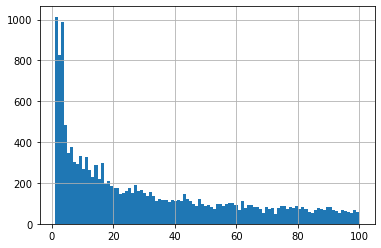

In [10]:
df_played[df_played['games']<=100]['games'].hist(bins=100)

In [233]:
#analyzing the quarterbacks regression
#df_cox=df[df['position']=='QB'][['height', 'weight', 'draft_round','passing_attempts', 'passing_completions', 'passing_yards','passing_touchdowns', 'passing_interceptions', 'passing_sacks','rushing_attempts', 'rushing_yards', 'rushing_touchdowns','games', 'min_year', 'lifetime', 'draft_age','retired']]


cph = lifelines.CoxPHFitter()
cph.fit(df_cox.drop(['player_id', 'seasons', 'grad_completion','grad_TD-INT'], axis=1), duration_col='lifetime', event_col='retired')

cph.print_summary()


<lifelines.CoxPHFitter: fitted with 590 total observations, 62 right-censored observations>
             duration col = 'lifetime'
                event col = 'retired'
      baseline estimation = breslow
   number of observations = 590
number of events observed = 528
   partial log-likelihood = -2671.88
         time fit was run = 2021-10-18 17:28:14 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
height           -0.01       0.99       0.02            -0.04             0.03                 0.96                 1.03
weight           -0.01       0.99       0.00            -0.02             0.00                 0.98                 1.00
games            -0.08       0.93       0.02            -0.11            -0.04                 0.89                 0.96
min_year          0.01       1.01       0.00             0.00             0.02                 1.00                 1.02
draft_age         0.13       1.14       0.04             0.06             0.21                 1.06                 1.23
completion        0.91       2.49       0.16             0.61             1.22                 1.84                 3.38
yards_per_pass   -0.08       0.92       0.03            -0.14            -0.02                 0.87                 0.98
TD-INT           -0.73       0.48       0.18            -1.09            -0.37                 0.34                 0.69
TD_per_pass      -0.22       0.80       2.55            -5.22             4.78                 0.01               119.52
rush_pass_ratio   0.04       1.04       0.07            -0.10             0.17                 0.90                 1.19
pass_per_game    -0.04       0.96       0.01            -0.05            -0.02                 0.95                 0.98
sack_per_game     0.12       1.13       0.10            -0.07             0.31                 0.93                 1.36
drafted          -0.10       0.91       0.10            -0.30             0.11                 0.74                 1.11

                    z      p   -log2(p)
covariate                              
height          -0.35   0.72       0.46
weight          -1.57   0.12       3.11
games           -4.27 <0.005      15.66
min_year         2.65   0.01       6.96
draft_age        3.47 <0.005      10.89
completion       5.87 <0.005      27.81
yards_per_pass  -2.68   0.01       7.08
TD-INT          -3.95 <0.005      13.63
TD_per_pass     -0.09   0.93       0.10
rush_pass_ratio  0.52   0.61       0.72
pass_per_game   -4.16 <0.005      14.95
sack_per_game    1.25   0.21       2.25
drafted         -0.93   0.35       1.51
---
Concordance = 0.77
Partial AIC = 5369.75
log-likelihood ratio test = 331.42 on 13 df
-log2(p) of ll-ratio test = 206.64

0.9705789326031808

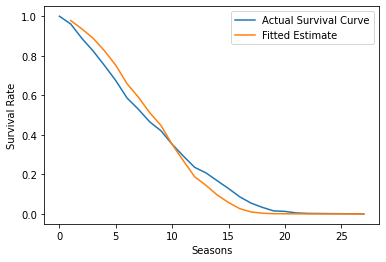

In [246]:
from sklearn.metrics import r2_score

km=lifelines.fitters.kaplan_meier_fitter.KaplanMeierFitter()
km.fit(df_cox['lifetime'], df_cox['retired'])
plt.plot(km.survival_function_, label='Actual Survival Curve')
plt.plot(cph.baseline_survival_, label='Fitted Estimate')
plt.xlabel('Seasons')
plt.ylabel('Survival Rate')
plt.legend()
r2_score(km.survival_function_[1:20].iloc[:,0], cph.baseline_survival_[0:20].iloc[:,0])


ICI =  0.05990601899498682
E50 =  0.06752789976642476


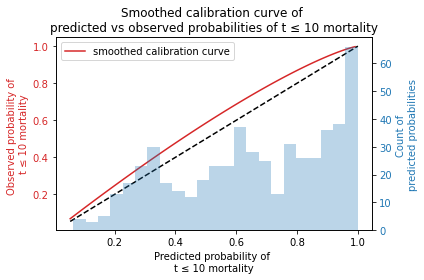

In [250]:
#calibration curves
from lifelines.calibration import survival_probability_calibration
survival_probability_calibration(cph, df_cox[df_cox['retired']==1], t0=10)
a=1

'completion'

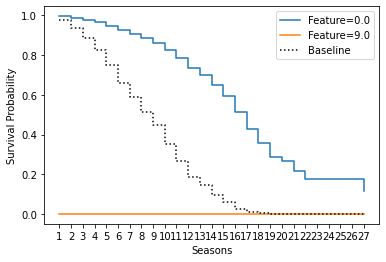

In [253]:
#plotting the actual survival curve with some covariate together

variavel='completion'

minimum=df_cox[variavel].min()
mean=df_cox[variavel].mean()
maximum=df_cox[variavel].max()
ax=cph.plot_partial_effects_on_outcome(variavel, values=[minimum, maximum])
ax.legend(['Feature='+str(round(minimum,2)), 'Feature='+str(round(maximum,2)), 'Baseline'])#, loc='lower right')
ax.set_xlabel('Seasons')
ax.set_ylabel('Survival Probability')
ax.set_xticks(range(1,28))
variavel

In [271]:
#predicting some notable quarterbacks

brady=df_profiles[df_profiles['name']=='Tom Brady ']['player_id'].values[0]
peyton=df_profiles[df_profiles['name']=='Peyton Manning']['player_id'].values[0]
favre=df_profiles[df_profiles['name']=='Brett Favre ']['player_id'].values[0]
luck=df_profiles[df_profiles['name']=='Andrew Luck ']['player_id'].values[0]
vick=df_profiles[df_profiles['name']=='Michael Vick']['player_id'].values[0]
rivers=df_profiles[df_profiles['name']=='Philip Rivers']['player_id'].values[0]
romo=df_profiles[df_profiles['name']=='Tony Romo ']['player_id'].values[0]
brees=df_profiles[df_profiles['name']=='Drew Brees']['player_id'].values[0]
leaf=df_profiles[df_profiles['name']=='Ryan Leaf']['player_id'].values[0]
sanchez=df_profiles[df_profiles['name']=='Mark Sanchez']['player_id'].values[0]
cutler=df_profiles[df_profiles['name']=='Jay Cutler ']['player_id'].values[0]
bigben=df_profiles[df_profiles['name']=='Ben Roethlisberger']['player_id'].values[0]

cph.predict_expectation(df_cox[df_cox['player_id']==leaf].drop('player_id', axis=1))
#cph.predict_median(df_cox[df_cox['player_id']==sanchez].drop('player_id', axis=1))
#cph.predict_survival_function(df_cox[df_cox['player_id']==sanchez].drop('player_id', axis=1))


318    6.863608
dtype: float64

In [262]:
df_cox[df_cox['player_id']==bigben]

,player_id,height,weight,games,min_year,lifetime,draft_age,retired,seasons,completion,yards_per_pass,TD-INT,TD_per_pass,rush_pass_ratio,pass_per_game,sack_per_game,drafted,grad_completion,grad_TD-INT
388,18977,77,240.0,15.428571,2004,14.0,22.0,0,14,1.564767,12.288579,1.774359,0.077945,0.072416,32.157407,2.407407,1,0.001952,0.037454


<AxesSubplot:>

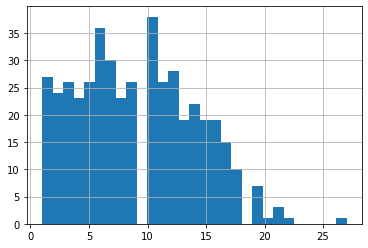

In [21]:
df_cox[df_cox['lifetime']==27]
df_cox[df_cox['player_id']==1853]
#df_cox.groupby('min_year')['lifetime'].max().plot()
df_cox['lifetime'].hist(bins=29)

In [290]:
#running sum - when a qb stats are stable enough so we can apply our model?


df_stats_run=df_games.drop(['game_number', 'passing_rating'], axis=1).groupby(['player_id', 'year']).sum().reset_index()
df_played_run=df_games.groupby(['player_id', 'year']).size().reset_index()
df_played_run=df_played_run.rename(columns = {0: 'games'})

df_stats_run=df_stats_run.merge(df_played_run, how='inner', on=['player_id', 'year'])

df_stats_run=df_stats_run.groupby(['player_id', 'year']).sum().groupby(level=0).cumsum().reset_index()

df_run=df_stats_run[['year', 'player_id','passing_attempts', 'passing_completions', 'passing_yards','passing_touchdowns', 'passing_interceptions', 'passing_sacks','rushing_attempts', 'rushing_yards','games']]
df_run['completion']=(df_run['passing_attempts']/df_run['passing_completions'].replace(to_replace=0, value=1)).fillna(0)
df_run['yards_per_pass']=(df_run['passing_yards']/df_run['passing_completions']).fillna(0)
df_run['TD-INT']=(df_run['passing_touchdowns']/df_run['passing_interceptions'].replace(to_replace=0, value=1))
df_run['TD_per_pass']=(df_run['passing_touchdowns']/df_run['passing_completions']).fillna(0)
df_run['rush_pass_ratio']=(df_run['rushing_attempts']/df_run['passing_attempts'].replace(to_replace=0, value=1)).fillna(0)
df_run['pass_per_game']=(df_run['passing_attempts']/df_run['games']).fillna(0)
df_run['sack_per_game']=(df_run['passing_sacks']/df_run['games']).fillna(0)
#adjusting games
df_run['games2']=df_run['games']
df_run=df_run.drop(['passing_attempts', 'passing_sacks', 'passing_completions', 'passing_yards','rushing_yards', 'passing_interceptions', 'passing_touchdowns', 'rushing_attempts'], axis=1)



df_run[df_run['player_id']==sanchez].head(5)

<ipython-input-290-39779d4753c4>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_run['completion']=(df_run['passing_attempts']/df_run['passing_completions'].replace(to_replace=0, value=1)).fillna(0)
<ipython-input-290-39779d4753c4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_run['yards_per_pass']=(df_run['passing_yards']/df_run['passing_completions']).fillna(0)
<ipython-input-290-39779d4753c4>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

,year,player_id,games,completion,yards_per_pass,TD-INT,TD_per_pass,rush_pass_ratio,pass_per_game,sack_per_game,games2
66825,2009,19427,18,1.822785,12.586498,0.727273,0.067511,0.097222,24.000000,1.500000,18
66826,2010,19427,37,1.806678,12.108963,1.055556,0.066784,0.074903,27.783784,1.540541,37
66827,2011,19427,53,1.791334,11.817560,1.185185,0.072976,0.072565,29.641509,1.811321,53
66828,2012,19427,68,1.802315,11.796082,1.069444,0.068566,0.067194,29.764706,1.911765,68
66829,2014,19427,77,1.766086,11.858441,1.096386,0.068887,0.072868,30.298701,1.987013,77


In [293]:
#grouping Brady and Cutler predictions

df2=df_profiles.merge(df_run, on='player_id', how='inner')
df2=df2[df2['height']!='None']
df2['min_year']=df2['draft_year']
df2['draft_age']=df2['draft_year']-[int(x[0:4]) for x in df2['birth_date']]
df2['height2']=[str(x)[0] for x in df2['height']]
df2=df2[df2['height2']!='N']
df2['height']=[int(str(x)[0])*12+int(str(x)[2]) for x in df2['height']]
df2['draft_round']=df2['draft_round'].fillna(100)
df2['drafted']=np.where(df2['draft_round']>7,0, 1)
df2=df2[df2['games']>5]
df2['seasons']=df2['year']-df2['draft_year']+1
df2['games']=df2['games']/df2['seasons']

#bringing gradient
df2=df2.merge(df_min, on='player_id', how='inner', suffixes=('', '_rookie'))

for field in grad_field:
    df2['grad_'+field]=(df2[field]-df2[field+'_rookie'])/df2['seasons']
    df2=df2.drop(field+'_rookie', axis=1)

#any data pertraining 2017 is censored (we don't know it the guy came back in 2018)

#df=df.drop(['height2', 'max_year', 'draft_year', 'birth_date', 'seasons'], axis=1)


cph.predict_expectation(df2[df2['player_id']==brady].drop('player_id', axis=1))

31165    10.851370
31166    13.575178
31167    15.030444
31168    16.112647
31169    16.513079
           ...    
31177    19.883010
31178    20.195685
31179    20.553698
31180    20.949644
31181    21.162667
Length: 17, dtype: float64

<ipython-input-296-36e0666da380>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['seasons']=df_plot['seasons']


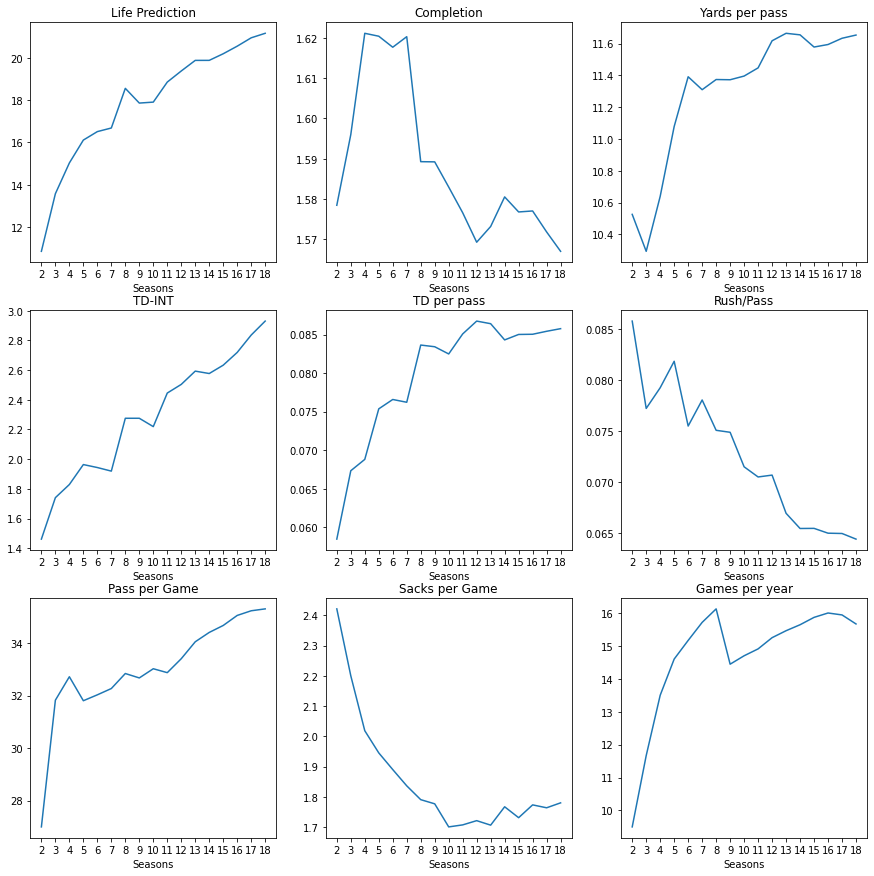

In [296]:
#brady evolution

plt.figure(figsize=(15,15))
df_plot=df2[(df2['player_id']==brady)&(df2['games']>5)]
df_plot['seasons']=df_plot['seasons']
df_plot2=df2[(df2['player_id']==brady)&(df2['games2']>5)]
columns=list(df_run.columns)



#prediction
plt.subplot(3, 3, 1)
df_run_prediction=cph.predict_expectation(df2[df2['player_id']==brady].drop('player_id', axis=1))
plt.plot(df_plot['seasons'],df_run_prediction.values)
plt.xlabel('Seasons')
plt.title('Life Prediction')
plt.xticks(df_plot['seasons'])

#completion
plt.subplot(3, 3, 2)
plt.plot(df_plot['seasons'],df_plot['completion'])
#plt.plot(df_plot2['games2'],df_plot2['grad_TD-INT'])
plt.xlabel('Seasons')
plt.title('Completion')
plt.xticks(df_plot['seasons'])

#yard per pass
plt.subplot(3, 3, 3)
plt.plot(df_plot['seasons'],df_plot['yards_per_pass'])
plt.xlabel('Seasons')
plt.title('Yards per pass')
plt.xticks(df_plot['seasons'])

#TD-INT
plt.subplot(3, 3, 4)
plt.plot(df_plot['seasons'],df_plot['TD-INT'])
plt.xlabel('Seasons')
plt.title('TD-INT')
plt.xticks(df_plot['seasons'])

#TD pass
plt.subplot(3, 3, 5)
plt.plot(df_plot['seasons'],df_plot['TD_per_pass'])
plt.xlabel('Seasons')
plt.title('TD per pass')
plt.xticks(df_plot['seasons'])

#rush_pass
plt.subplot(3, 3, 6)
plt.plot(df_plot['seasons'],df_plot['rush_pass_ratio'])
plt.xlabel('Seasons')
plt.title('Rush/Pass')
plt.xticks(df_plot['seasons'])

#pass game
plt.subplot(3, 3, 7)
plt.plot(df_plot['seasons'],df_plot['pass_per_game'])
plt.xlabel('Seasons')
plt.title('Pass per Game')
plt.xticks(df_plot['seasons'])

#sack game
plt.subplot(3, 3, 8)
plt.plot(df_plot['seasons'],df_plot['sack_per_game'])
plt.xlabel('Seasons')
plt.title('Sacks per Game')
plt.xticks(df_plot['seasons'])

#games
plt.subplot(3, 3, 9)
plt.plot(df_plot2['seasons'],df_plot2['games'])
plt.xlabel('Seasons')
plt.title('Games per year')
plt.xticks(df_plot['seasons'])

a=1

Text(0.5, 1.0, 'Games per year')

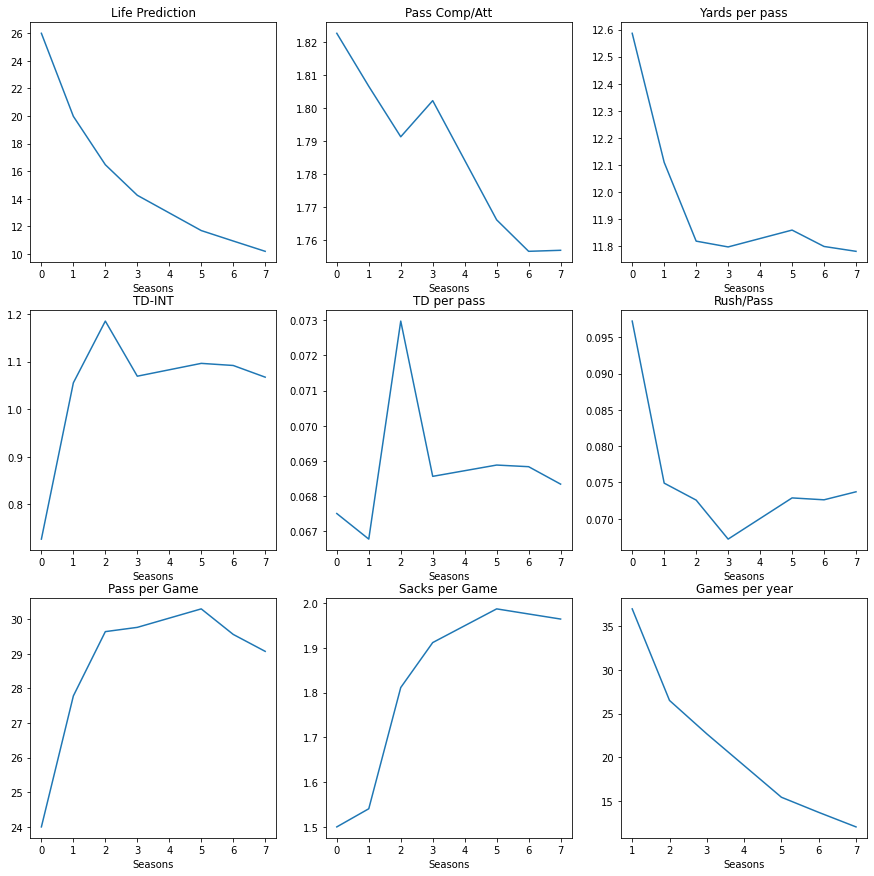

In [286]:
#cutler evolution

player=sanchez
plt.figure(figsize=(15,15))
df_plot=df2[(df2['player_id']==player)&(df2['games2']>5)]
df_plot2=df2[(df2['player_id']==player)&(df2['games2']>5)]
columns=list(df_run.columns)

#prediction
plt.subplot(3, 3, 1)
df_run_prediction=cph.predict_expectation(df2[df2['player_id']==player].drop('player_id', axis=1))
plt.plot(df_plot['seasons'],df_run_prediction.values)
plt.xlabel('Seasons')
plt.title('Life Prediction')

#completion
plt.subplot(3, 3, 2)
plt.plot(df_plot['seasons'],df_plot['completion'])
plt.xlabel('Seasons')
plt.title('Pass Comp/Att')

#yard per pass
plt.subplot(3, 3, 3)
plt.plot(df_plot['seasons'],df_plot['yards_per_pass'])
plt.xlabel('Seasons')
plt.title('Yards per pass')

#TD-INT
plt.subplot(3, 3, 4)
plt.plot(df_plot['seasons'],df_plot['TD-INT'])
plt.xlabel('Seasons')
plt.title('TD-INT')

#TD pass
plt.subplot(3, 3, 5)
plt.plot(df_plot['seasons'],df_plot['TD_per_pass'])
plt.xlabel('Seasons')
plt.title('TD per pass')

#rush_pass
plt.subplot(3, 3, 6)
plt.plot(df_plot['seasons'],df_plot['rush_pass_ratio'])
plt.xlabel('Seasons')
plt.title('Rush/Pass')

#pass game
plt.subplot(3, 3, 7)
plt.plot(df_plot['seasons'],df_plot['pass_per_game'])
plt.xlabel('Seasons')
plt.title('Pass per Game')

#sack game
plt.subplot(3, 3, 8)
plt.plot(df_plot['seasons'],df_plot['sack_per_game'])
plt.xlabel('Seasons')
plt.title('Sacks per Game')

#games
plt.subplot(3, 3, 9)
plt.plot(df_plot2['seasons'],df_plot2['games'])
plt.xlabel('Seasons')
plt.title('Games per year')

<ipython-input-297-3a4bd30eb93a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['seasons']=df_plot['seasons']+1
<ipython-input-297-3a4bd30eb93a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['seasons']=df_plot['seasons']+1
<ipython-input-297-3a4bd30eb93a>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

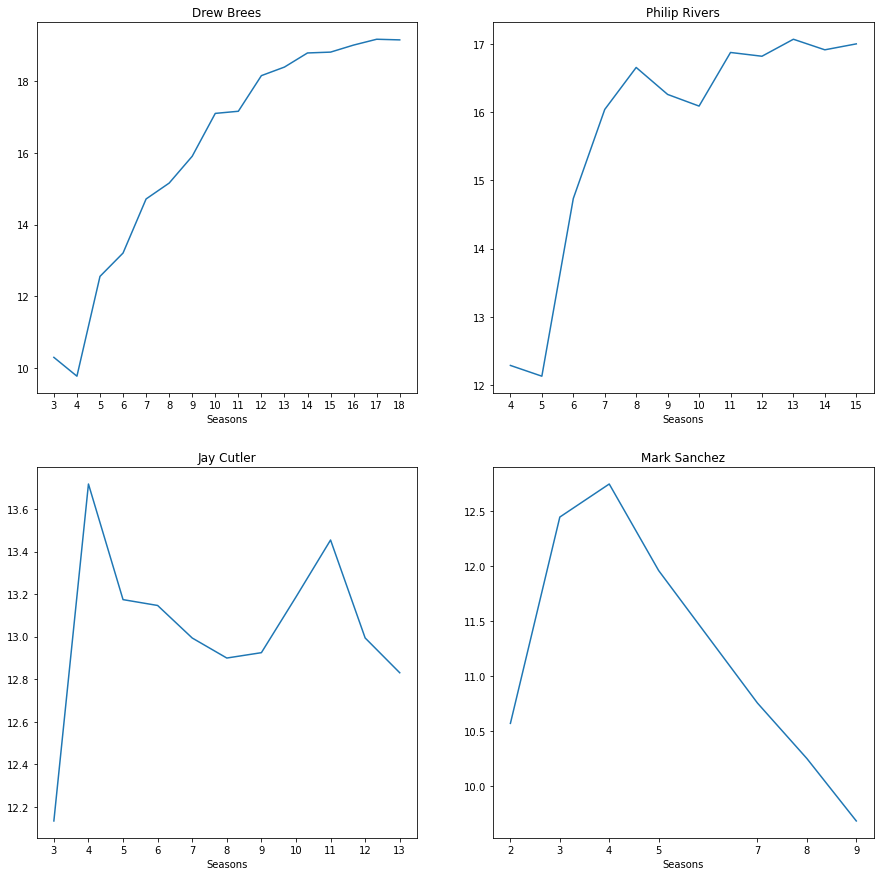

In [297]:
#different players grid

plt.figure(figsize=(15,15))

#prediction
plt.subplot(2, 2, 1)
df_plot=df2[(df2['player_id']==brees)&(df2['games']>5)]
df_plot['seasons']=df_plot['seasons']+1
df_plot2=df2[(df2['player_id']==brees)&(df2['games2']>5)]
df_run_prediction=cph.predict_expectation(df2[df2['player_id']==brees].drop('player_id', axis=1))
plt.plot(df_plot['seasons'],df_run_prediction.values)
plt.xlabel('Seasons')
plt.title('Drew Brees')
plt.xticks(df_plot['seasons'])

plt.subplot(2, 2, 2)
df_plot=df2[(df2['player_id']==rivers)&(df2['games']>5)]
df_plot['seasons']=df_plot['seasons']+1
df_plot2=df2[(df2['player_id']==rivers)&(df2['games2']>5)]
df_run_prediction=cph.predict_expectation(df2[df2['player_id']==rivers].drop('player_id', axis=1))
plt.plot(df_plot['seasons'],df_run_prediction.values)
plt.xlabel('Seasons')
plt.title('Philip Rivers')
plt.xticks(df_plot['seasons'])

plt.subplot(2, 2, 3)
df_plot=df2[(df2['player_id']==cutler)&(df2['games']>5)]
df_plot['seasons']=df_plot['seasons']+1
df_plot2=df2[(df2['player_id']==cutler)&(df2['games2']>5)]
df_run_prediction=cph.predict_expectation(df2[df2['player_id']==cutler].drop('player_id', axis=1))
plt.plot(df_plot['seasons'],df_run_prediction.values)
plt.xlabel('Seasons')
plt.title('Jay Cutler')
plt.xticks(df_plot['seasons'])

plt.subplot(2, 2, 4)
df_plot=df2[(df2['player_id']==sanchez)&(df2['games']>5)]
df_plot['seasons']=df_plot['seasons']+1
df_plot2=df2[(df2['player_id']==sanchez)&(df2['games2']>5)]
df_run_prediction=cph.predict_expectation(df2[df2['player_id']==sanchez].drop('player_id', axis=1))
plt.plot(df_plot['seasons'],df_run_prediction.values)
plt.xlabel('Seasons')
plt.title('Mark Sanchez')
plt.xticks(df_plot['seasons'])

a=1

In [282]:
df_cox[df_cox['player_id']==brees]

,player_id,height,weight,games,min_year,lifetime,draft_age,retired,seasons,completion,yards_per_pass,TD-INT,TD_per_pass,rush_pass_ratio,pass_per_game,sack_per_game,drafted,grad_completion,grad_TD-INT
447,2328,72,209.0,15.058824,2001,17.0,22.0,0,17,1.497347,11.341916,2.186147,0.078808,0.047421,37.480469,1.523438,1,-0.009023,0.06242


In [295]:
df2[df2['player_id']==brady]
#df_run[df_run['player_id']==brady]
#columns

,player_id,name,position,height,weight,birth_date,draft_round,draft_year,year,games,...,pass_per_game,sack_per_game,games2,min_year,draft_age,height2,drafted,seasons,grad_completion,grad_TD-INT
31165,2240,Tom Brady,QB,76,225.0,1977-08-03,6.0,2000.0,2001,9.500000,...,27.000000,2.421053,19,2000.0,23.0,6,1,2.0,0.000000,0.000000
31166,2240,Tom Brady,QB,76,225.0,1977-08-03,6.0,2000.0,2002,11.666667,...,31.828571,2.200000,35,2000.0,23.0,6,1,3.0,0.005842,0.093067
31167,2240,Tom Brady,QB,76,225.0,1977-08-03,6.0,2000.0,2003,13.500000,...,32.722222,2.018519,54,2000.0,23.0,6,1,4.0,0.010660,0.091932
31168,2240,Tom Brady,QB,76,225.0,1977-08-03,6.0,2000.0,2004,14.600000,...,31.808219,1.945205,73,2000.0,23.0,6,1,5.0,0.008383,0.100420
31169,2240,Tom Brady,QB,76,225.0,1977-08-03,6.0,2000.0,2005,15.166667,...,32.032967,1.890110,91,2000.0,23.0,6,1,6.0,0.006531,0.080354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31177,2240,Tom Brady,QB,76,225.0,1977-08-03,6.0,2000.0,2013,15.642857,...,34.410959,1.767123,219,2000.0,23.0,6,1,14.0,0.000148,0.079670
31178,2240,Tom Brady,QB,76,225.0,1977-08-03,6.0,2000.0,2014,15.866667,...,34.676471,1.731092,238,2000.0,23.0,6,1,15.0,-0.000110,0.078107
31179,2240,Tom Brady,QB,76,225.0,1977-08-03,6.0,2000.0,2015,16.000000,...,35.058594,1.773438,256,2000.0,23.0,6,1,16.0,-0.000088,0.078598
31180,2240,Tom Brady,QB,76,225.0,1977-08-03,6.0,2000.0,2016,15.941176,...,35.236162,1.763838,271,2000.0,23.0,6,1,17.0,-0.000389,0.080855


In [281]:
df_current=pd.read_csv('2021_qbs.csv', sep=';', decimal=',')
list(cph.predict_expectation(df_current))


[14.881898266421969,
 17.93220325209075,
 21.39317679127222,
 17.677737824084975,
 15.19477589729696,
 18.96392843890676,
 11.737343412518564,
 10.749337181930207,
 16.672688878722294,
 17.83910095853307,
 19.404817876942417,
 24.36506005774378,
 23.860637153426758,
 18.540776511882022,
 17.691979209600774,
 14.637872692095272,
 16.061914242484615,
 19.73555289056863]